<a href="https://colab.research.google.com/github/Wessbejaoui/Capstone/blob/main/Capstone_Diabetes_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detailed dataset comprising health and demographic data of 100,000 individuals, aimed at facilitating diabetes-related research and predictive modeling. This dataset includes information on gender, age, location, race, hypertension, heart disease, smoking history, BMI, HbA1c level, blood glucose level, and diabetes status.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    precision_score, recall_score, confusion_matrix,
    precision_recall_curve, roc_curve
)

RANDOM_STATE = 42
sns.set(context="notebook", style="whitegrid")

In [4]:
df = pd.read_csv("sample_data/diabetes_dataset_with_notes.csv")
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,clinical_notes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,"Overweight, advised dietary and exercise modif..."
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,Healthy BMI range.
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,"Young patient, generally lower risk but needs ..."
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0,"Overweight, advised dietary and exercise modif..."
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0,"Healthy BMI range. High HbA1c level, indicativ..."


In [5]:
# Dataset overview
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [6]:
# Descriptive statistics
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [7]:
df_clean = df.copy()

In [8]:
# Drop columns I won't use for now. drop clinical_notes (text data)
df_clean = df_clean.drop(columns=['clinical_notes'])

In [9]:
# Feature Engineering. Create 'high_glucose' flag (based on glucose level threshold)
df_clean['high_glucose'] = (df_clean['blood_glucose_level'] > 140).astype(int)

In [10]:
# One-hot encode categorical features
categorical_cols = ['gender', 'location', 'smoking_history']
numeric_cols = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']

In [11]:
# ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
], remainder='passthrough')

In [12]:
# I apply the transformation
X_transformed = preprocessor.fit_transform(df_clean)

# Get the shape of transformed data
X_transformed_shape = X_transformed.shape

X_transformed_shape

(100000, 78)

This is the shape of the cleaned and transformed dataset:

* 100000 rows → You have 100,000 patient records
* 78 columns (features) → These are the final input variables after:

1.   Standardizing numerical variables (age, bmi, etc.)
2.   Keeping binary features like hypertension, heart_disease, race flags
3.   One-hot encoding categorical variables (gender, location, smoking_history)
4.   Adding the new engineered feature: high_glucose


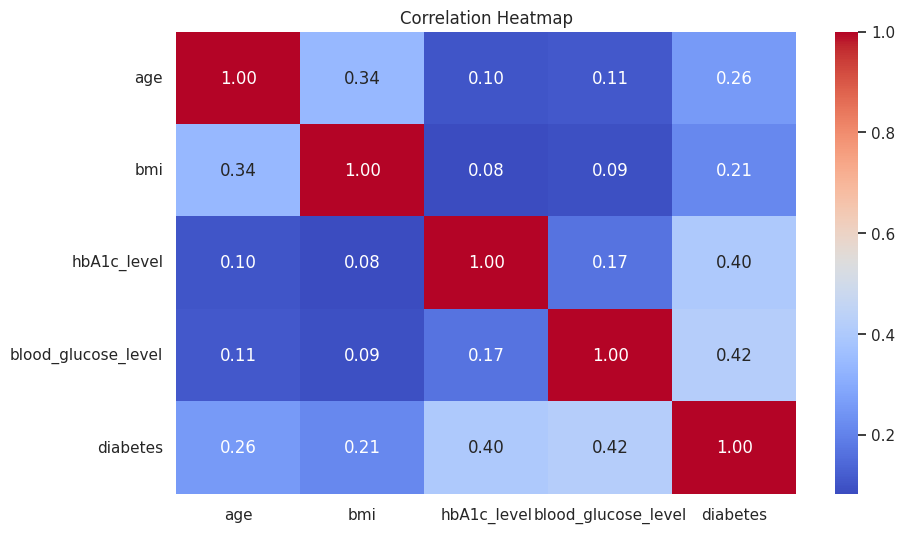

In [13]:
# Select numeric columns for visualization
numeric_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']

# Correlation Heatmap
plt.figure(figsize=(10, 6))
corr = df_clean[numeric_features + ['diabetes']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

- hbA1c_level and blood_glucose_level show the strongest positive correlation with diabetes, which is expected as these are key indicators of blood sugar control.
- age and bmi also show positive correlations with diabetes, suggesting that older individuals and those with higher BMI are more likely to have diabetes.
- The correlations between the numerical features themselves (e.g., age and bmi) are relatively weak, indicating that these features provide somewhat independent information.

| Feature                   | Correlation with `diabetes`         |
| ------------------------- | ----------------------------------- |
| **blood\_glucose\_level** | **0.42** → Strongest predictor      |
| **hbA1c\_level**          | **0.40** → Clinically accurate      |
| **age**                   | 0.26 → Older patients = higher risk |
| **bmi**                   | 0.21 → Mild correlation             |


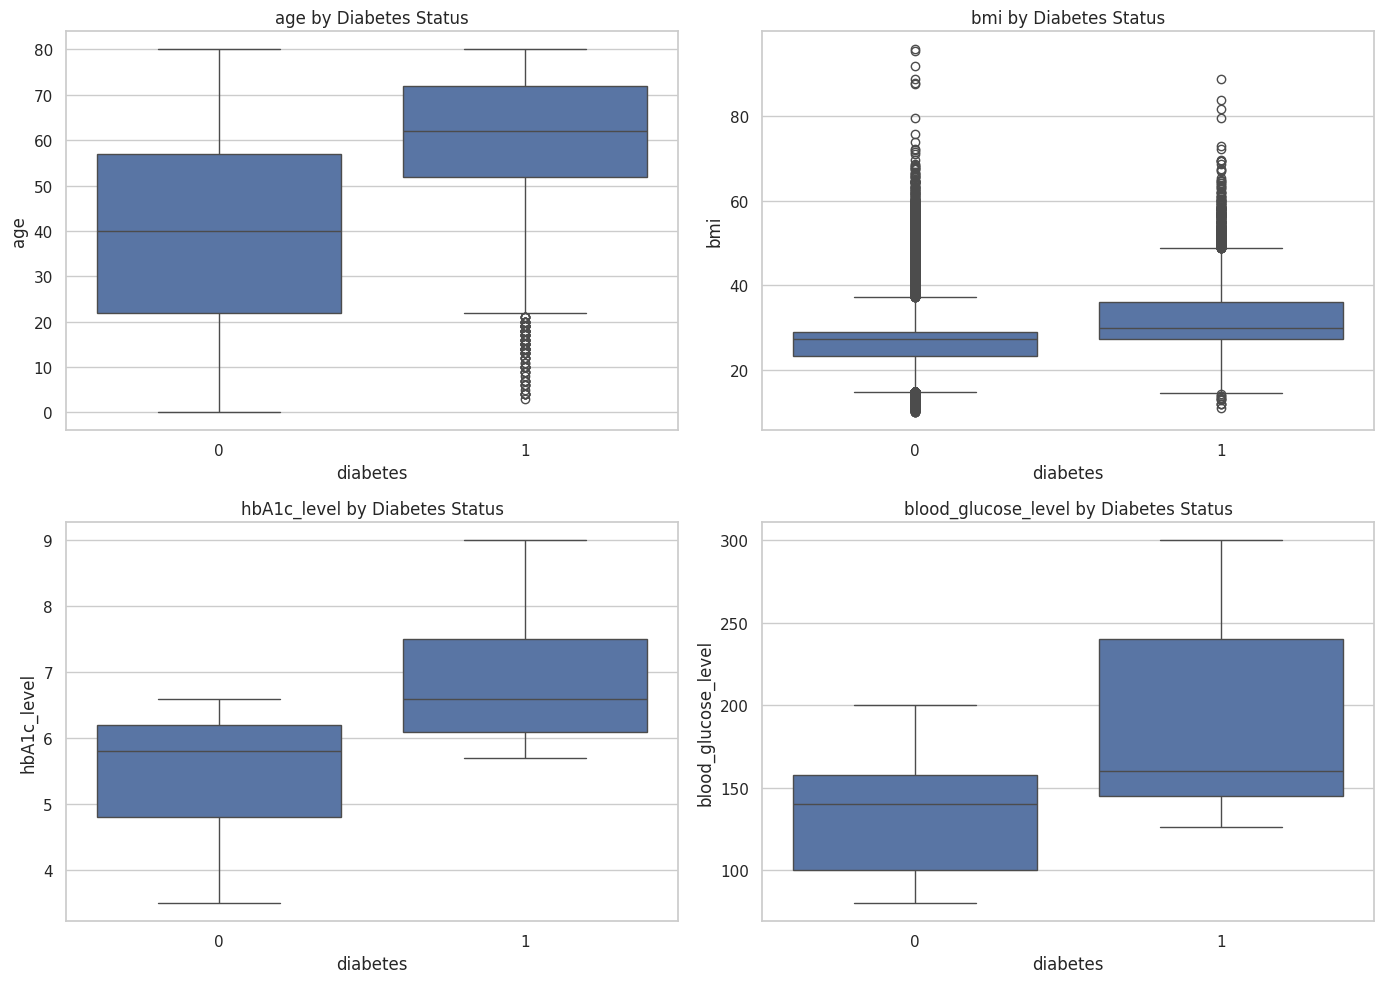

In [14]:
# Boxplots to detect outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, feature in zip(axes.ravel(), numeric_features):
    sns.boxplot(data=df_clean, x='diabetes', y=feature, ax=ax)
    ax.set_title(f'{feature} by Diabetes Status')
plt.tight_layout()
plt.show()

- The boxplots clearly show that individuals with diabetes (diabetes=1) tend to have significantly higher values for age, bmi, hbA1c_level, and blood_glucose_level compared to individuals without diabetes (diabetes=0).
- There are outliers present in the age and bmi features for both diabetes and non-diabetes groups.

blood_glucose_level:

- Non-diabetic: mostly under 140

- Diabetic: values spread wide, many >200 → heavy right skew and outliers

hbA1c_level:

- Diabetic group has higher medians (>6.5)

BMI:

- Wide spread in both groups; some values >60 or even 90 are extreme

Age:

- Expected range, but a few cases near 0 suggest infant entries (worth checking)

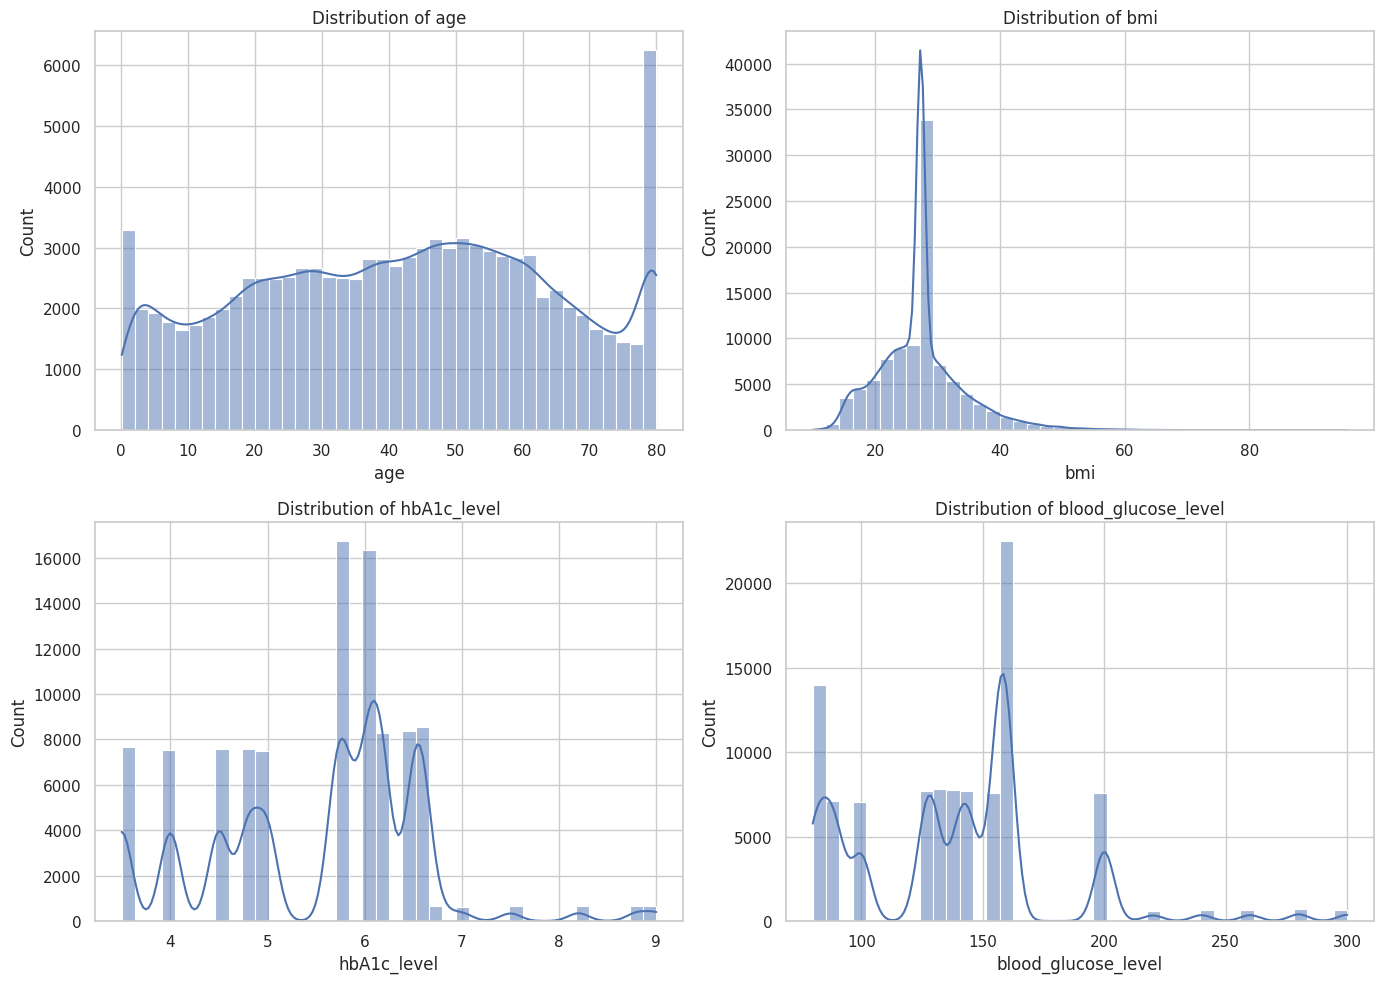

In [15]:
# Distributions (Histograms)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for ax, feature in zip(axes.ravel(), numeric_features):
    sns.histplot(df_clean[feature], kde=True, bins=40, ax=ax)
    ax.set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

- The distribution of age appears somewhat bimodal, with peaks around younger and older age groups.
- BMI and glucose are right-skewed. The BMI distribution is skewed to the right, indicating a higher frequency of lower BMI values and a tail extending towards higher BMI values.
- The hbA1c_level and blood_glucose_level distributions show multiple peaks, suggesting potential groupings or thresholds within these levels related to diabetes status.HbA1c is relatively normal with a peak ~5.5

Overall, the visuals support the understanding that age, bmi, hbA1c_level, and blood_glucose_level are important factors associated with diabetes in this dataset. The boxplots highlight the clear separation in these features between the two diabetes groups, and the histograms provide insights into the distribution patterns of the individual features.

# Capstone Project: Phase 2

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if "df_clean" not in globals():
    df_clean = df.copy()

# Use the core continuous features
candidate_cont = ["age", "bmi", "hbA1c_level", "blood_glucose_level"]
numeric_features = [c for c in candidate_cont if c in df_clean.columns]


In [17]:
# Use df_clean if it exists; otherwise fall back to df
if "df_clean" in globals():
    _data = df_clean.copy()
else:
    assert "df" in globals(), "Load your CSV into `df` first."
    _data = df.copy()

# Feature lists (keep it simple & readable)
numeric_feats = [c for c in ["age","bmi","hbA1c_level","blood_glucose_level",
                             "hypertension","heart_disease","year"]
                 if c in _data.columns]
categorical_feats = [c for c in ["gender","smoking_history"] if c in _data.columns]
extra_feats = [c for c in ["smoking_missing"] if c in _data.columns]

use_cols = numeric_feats + categorical_feats + extra_feats + ["diabetes"]
data = _data[use_cols].dropna(subset=["diabetes"]).copy()

X = data.drop(columns=["diabetes"])
y = data["diabetes"].astype(int)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Pos rate (train/test):", f"{y_train.mean():.3f} / {y_test.mean():.3f}")


Train: (75000, 9) | Test: (25000, 9)
Pos rate (train/test): 0.085 / 0.085


In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Dense (OK for Logistic/Tree)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [c for c in X.columns if c in (numeric_feats + extra_feats)]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [c for c in X.columns if c in categorical_feats]),
    ]
)

# Sparse-friendly (needed for Linear SVM + calibration)
preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), [c for c in X.columns if c in (numeric_feats + extra_feats)]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [c for c in X.columns if c in categorical_feats]),
    ],
    sparse_threshold=1.0
)


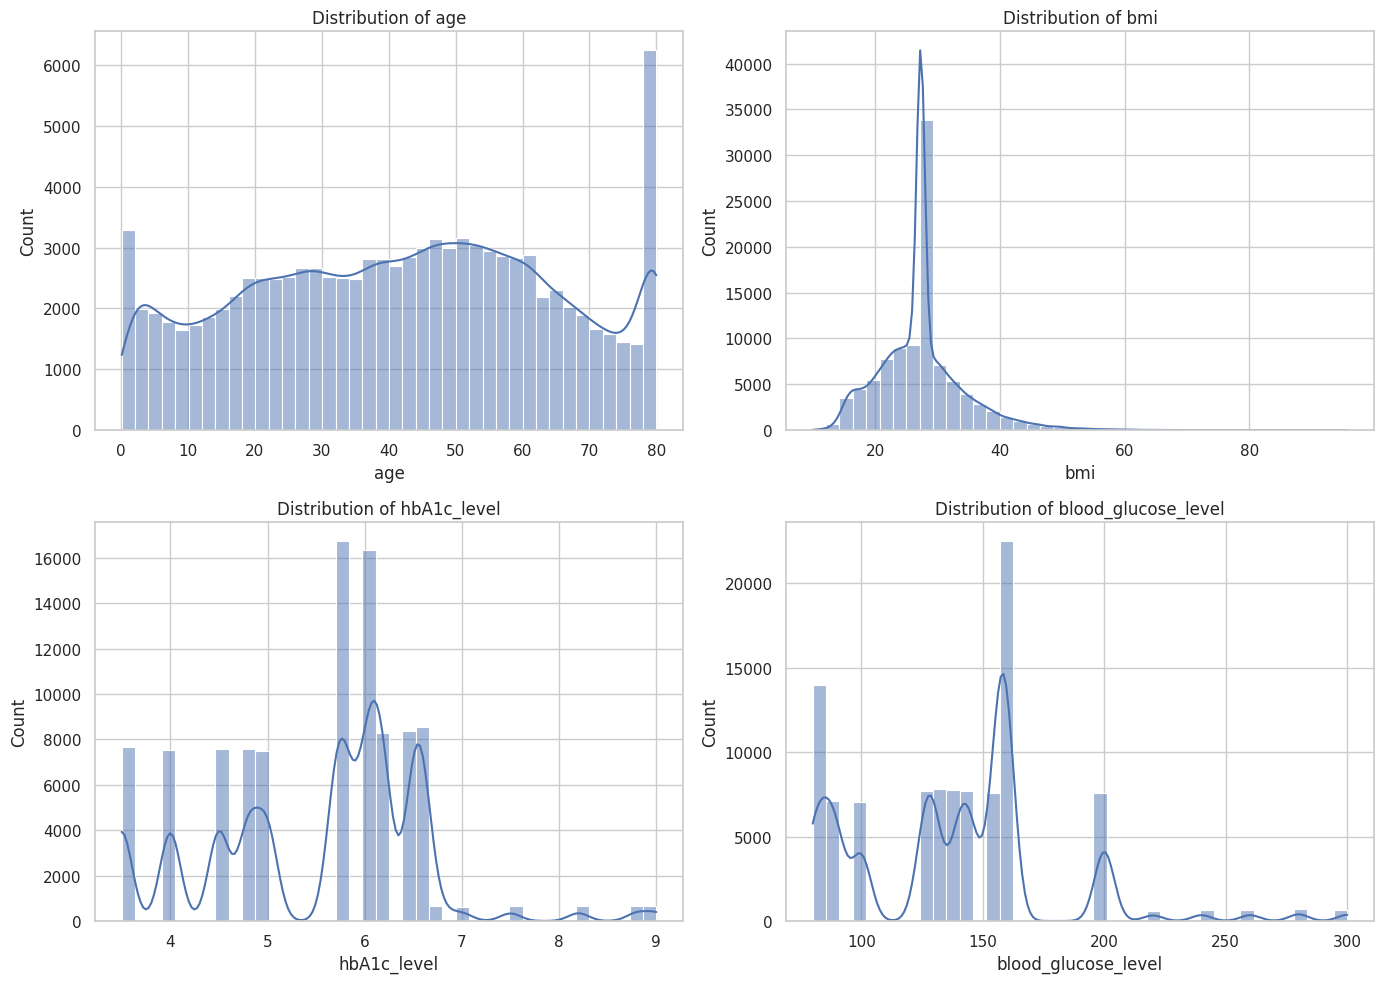

In [19]:
n = len(numeric_features)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5*nrows))
axes = np.atleast_1d(axes).ravel()

for i, feature in enumerate(numeric_features):
    sns.histplot(df_clean[feature], kde=True, bins=40, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Removing any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [20]:
# Make a working copy so we don't touch the original df
assert 'df' in globals(), "First run the cell that loads the CSV into a DataFrame named `df`."

df_clean = df.copy()

# 1) How many exact duplicate rows?
dup_count_before = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
print(f"Removed duplicate rows: {dup_count_before}")

# 2) What’s the diabetes prevalence? (helps pick metrics later)
assert 'diabetes' in df_clean.columns, "Expected a 'diabetes' column (0/1)."
target_counts = df_clean['diabetes'].value_counts().sort_index()
pos_rate = (target_counts.get(1, 0) / target_counts.sum()) * 100
print(f"Diabetes prevalence: {pos_rate:.2f}%  | counts -> 0:{target_counts.get(0,0)}, 1:{target_counts.get(1,0)}")

Removed duplicate rows: 14
Diabetes prevalence: 8.50%  | counts -> 0:91486, 1:8500


### Sanity Checks & Why They Matter

- **Work on `df_clean` (not `df`)**  
  We copy the raw DataFrame to `df_clean` before any edits. This preserves the original data so the notebook is fully restartable and reproducible.

- **Drop duplicates**  
  Duplicate rows artificially boost performance (the model “sees” the same example multiple times). Removing them prevents inflated metrics and leakage.

- **Quantify class balance (diabetes prevalence)**  
  The dataset is imbalanced (≈8–9% positives). Because of this, **accuracy is misleading**. We evaluate with **precision/recall** and **AUPRC**, and we choose a decision **threshold** to hit a target precision, then report the resulting recall.

In [21]:
# Treat 'No Info' as missing, but keep a flag so I don't lose signal
assert 'smoking_history' in df_clean.columns, "Expected a 'smoking_history' column."

# Count how many 'No Info' we have now
noinfo_before = (df_clean['smoking_history'] == 'No Info').sum()
print(f"'No Info' entries before: {noinfo_before:,}")

'No Info' entries before: 35,806


In [22]:
# Create a missingness flag (1 if originally 'No Info', else 0)
df_clean['smoking_missing'] = (df_clean['smoking_history'] == 'No Info').astype(int)

# Replace 'No Info' with actual NaN (so encoders/analysis treat it as missing)
df_clean['smoking_history'] = df_clean['smoking_history'].replace({'No Info': np.nan})

# Quick sanity check: show distribution (with MISSING label for NaNs)
dist = df_clean['smoking_history'].fillna('MISSING').value_counts()
print("\nsmoking_history distribution (after fix):")
print(dist.to_string())


smoking_history distribution (after fix):
smoking_history
MISSING        35806
never          35091
former          9352
current         9286
not current     6447
ever            4004


In [23]:
# Diabetes prevalence by smoking category (including missing)
prev = (df_clean
        .assign(smoking_hist_disp=df_clean['smoking_history'].fillna('MISSING'))
        .groupby('smoking_hist_disp')['diabetes']
        .mean()
        .sort_values(ascending=False) * 100).round(2)

print("\nDiabetes prevalence (%) by smoking_history:")
print(prev.to_string())


Diabetes prevalence (%) by smoking_history:
smoking_hist_disp
former         17.00
ever           11.79
not current    10.70
current        10.21
never           9.54
MISSING         4.06


In [24]:
# Does the missing flag carry signal?
flag_prev = (df_clean.groupby('smoking_missing')['diabetes'].mean() * 100).round(2)
print("\nDiabetes prevalence (%) by smoking_missing flag:")
print(flag_prev.rename(index={0: 'missing=0', 1: 'missing=1'}).to_string())


Diabetes prevalence (%) by smoking_missing flag:
smoking_missing
missing=0    10.98
missing=1     4.06


In [25]:
# Sanity: make sure the columns exist
assert 'age' in df_clean.columns, "Expected an 'age' column."
assert 'bmi' in df_clean.columns, "Expected a 'bmi' column."

# Remove clearly invalid ages (< 1 year)
age_invalid = (df_clean['age'] < 1)
print(f"Rows with age < 1 year: {age_invalid.sum()}")
df_clean = df_clean.loc[~age_invalid].reset_index(drop=True)

# BMI at the 1st and 99th percentiles (caps extreme outliers)
q01, q99 = df_clean['bmi'].quantile([0.01, 0.99])
bmi_before = df_clean['bmi'].copy()
df_clean['bmi'] = df_clean['bmi'].clip(lower=q01, upper=q99)
changed = (bmi_before != df_clean['bmi']).sum()
print(f"BMI clipped to [{q01:.1f}, {q99:.1f}] | values adjusted: {changed}")

# Quick summary after cleaning
summary = (df_clean[['age','bmi']]
           .agg(['min','mean','median','max'])
           .T.round(2))
print("\nSummary after cleaning:")
print(summary.to_string())

Rows with age < 1 year: 911
BMI clipped to [14.8, 48.8] | values adjusted: 1973

Summary after cleaning:
       min   mean  median    max
age   1.00  42.27   43.00  80.00
bmi  14.79  27.37   27.32  48.82


- Age < 1 in this context is almost certainly an error; dropping avoids nonsense inputs.

- Clipping BMI trims only the most extreme 1% tails, stabilizing models and plots without throwing away data.

In [26]:
# Chose the continuous variables we care about (keep it simple)

candidate_cont = ["age", "bmi", "hbA1c_level", "blood_glucose_level"]
numeric_features = [c for c in candidate_cont if c in df_clean.columns]
print("Numeric features to plot:", numeric_features)


Numeric features to plot: ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']


In [27]:
def quick_takeaway(series, target, name):
    """
    Simple big picture takeaway.
    Prints:
      - mean, median, min, max for the feature
      - how much higher/lower the average is for diabetics vs non-diabetics
    """
    # Basic stats
    s = series.dropna()
    mean_val = s.mean()
    med_val  = s.median()
    min_val  = s.min()
    max_val  = s.max()

    text = (f"{name}: mean={mean_val:.2f}, median={med_val:.2f}, "
            f"min={min_val:.2f}, max={max_val:.2f}")

    # Compare diabetics (1) vs non-diabetics (0), if target is provided
    if target is not None:
        tmp = (pd.DataFrame({'x': series, 'y': target})
                 .dropna(subset=['x', 'y']))
        if tmp['y'].nunique() == 2 and {0,1}.issubset(set(tmp['y'].unique())):
            mean0 = tmp.loc[tmp['y'] == 0, 'x'].mean()
            mean1 = tmp.loc[tmp['y'] == 1, 'x'].mean()
            diff = mean1 - mean0
            direction = "higher" if diff > 0 else "lower"
            text += f" | Diabetics have {abs(diff):.2f} {direction} {name} on average."

    print("👉", text)


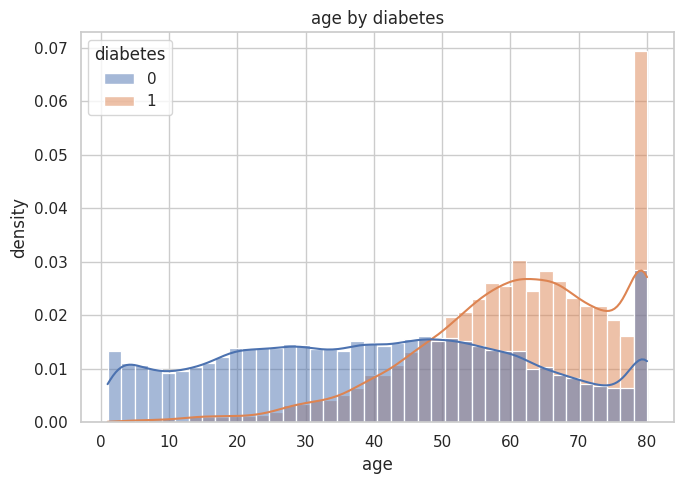

👉 age: mean=42.27, median=43.00, min=1.00, max=80.00 | Diabetics have 20.43 higher age on average.
👉 None


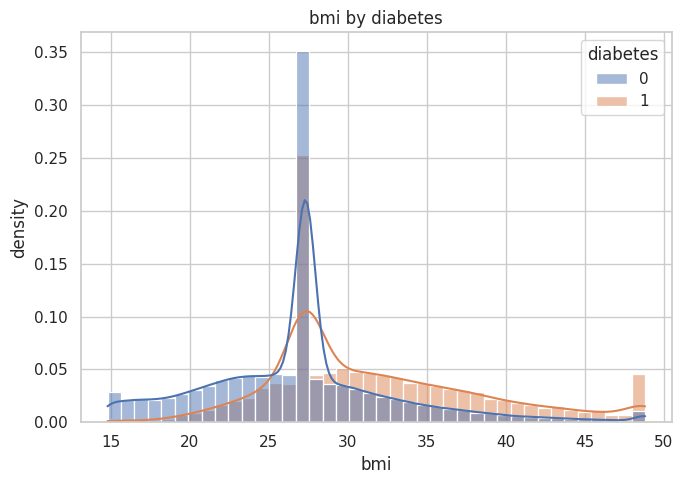

👉 bmi: mean=27.37, median=27.32, min=14.79, max=48.82 | Diabetics have 4.84 higher bmi on average.
👉 None


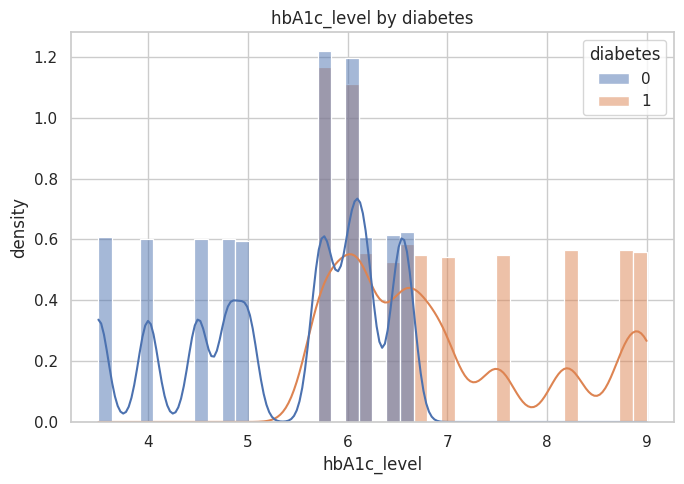

👉 hbA1c_level: mean=5.53, median=5.80, min=3.50, max=9.00 | Diabetics have 1.54 higher hbA1c_level on average.
👉 None


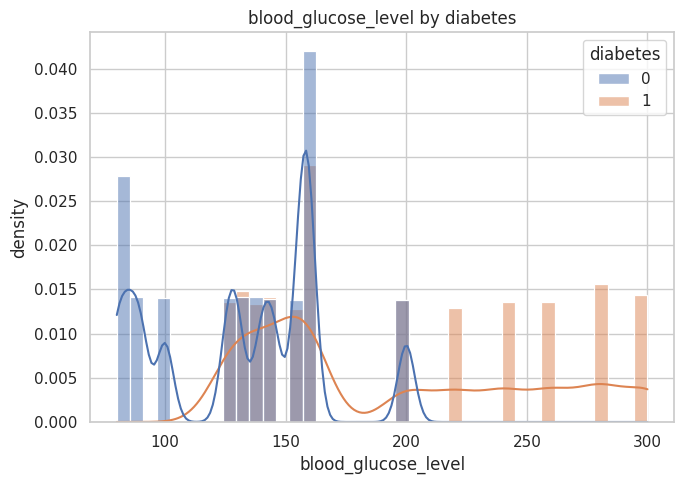

👉 blood_glucose_level: mean=138.11, median=140.00, min=80.00, max=300.00 | Diabetics have 61.24 higher blood_glucose_level on average.
👉 None


In [28]:
assert "diabetes" in df_clean.columns, "Expected a 'diabetes' column (0/1)."

for feature in numeric_features:
    plt.figure(figsize=(7, 5))
    sns.histplot(
        data=df_clean,
        x=feature,
        hue="diabetes",
        bins=40,
        kde=True,
        stat="density",
        common_norm=False
    )
    plt.title(f"{feature} by diabetes")
    plt.xlabel(feature)
    plt.ylabel("density")
    plt.tight_layout()
    plt.show()

    # One-line takeaway printed under each plot
    print("👉", quick_takeaway(df_clean[feature], df_clean["diabetes"], feature))

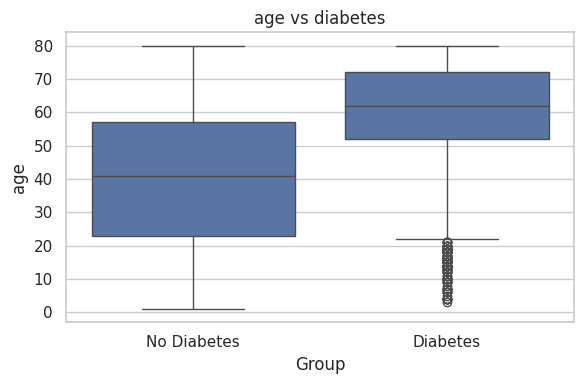

👉 age: mean=42.27, median=43.00, min=1.00, max=80.00 | Diabetics have 20.43 higher age on average.


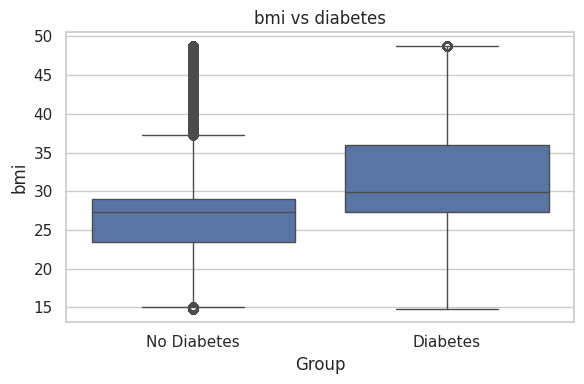

👉 bmi: mean=27.37, median=27.32, min=14.79, max=48.82 | Diabetics have 4.84 higher bmi on average.


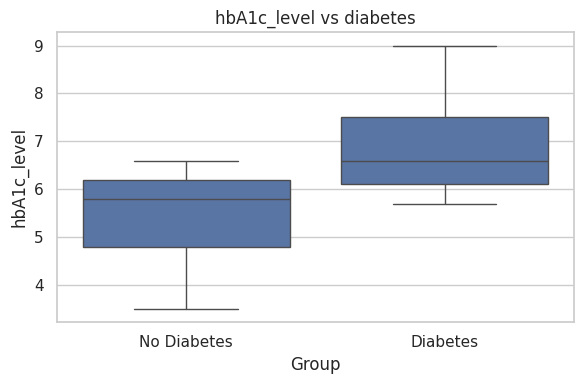

👉 hbA1c_level: mean=5.53, median=5.80, min=3.50, max=9.00 | Diabetics have 1.54 higher hbA1c_level on average.


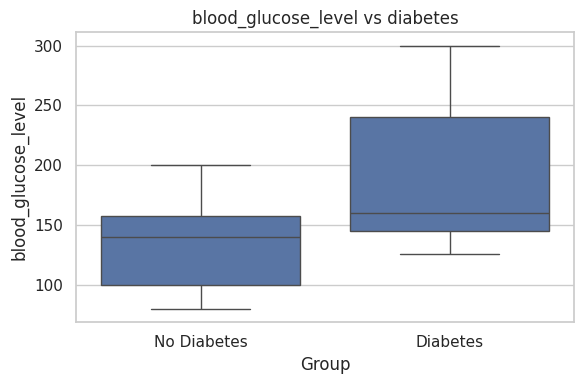

👉 blood_glucose_level: mean=138.11, median=140.00, min=80.00, max=300.00 | Diabetics have 61.24 higher blood_glucose_level on average.


In [29]:
assert "diabetes" in df_clean.columns, "Expected a 'diabetes' column (0/1)."

for feature in numeric_features:
    df_plot = df_clean[[feature, "diabetes"]].dropna()
    df_plot["diabetes_label"] = df_plot["diabetes"].map({0: "No Diabetes", 1: "Diabetes"})

    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_plot, x="diabetes_label", y=feature)
    plt.title(f"{feature} vs diabetes")
    plt.xlabel("Group")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

    # One-line takeaway
    quick_takeaway(df_clean[feature], df_clean["diabetes"], feature)

In [30]:
# The correlation between each numeric column and the target (0/1)
num_cols = df_clean.select_dtypes(include="number").columns.tolist()
if "diabetes" not in num_cols:
    raise ValueError("diabetes must be numeric (0/1) for this table.")

corr_to_target = (
    df_clean[num_cols]
    .corr(numeric_only=True)["diabetes"]
    .drop(labels=["diabetes"], errors="ignore")
    .sort_values(ascending=False)
    .to_frame(name="corr_with_diabetes")
)

corr_to_target.head(10).round(3)


,corr_with_diabetes
blood_glucose_level,0.421
hbA1c_level,0.402
age,0.257
bmi,0.214
hypertension,0.197
heart_disease,0.171
race:AfricanAmerican,0.005
race:Asian,0.004
race:Hispanic,-0.001
race:Caucasian,-0.002


##How to read this:

- Positive correlation → higher values tend to appear with diabetes (1).

- Negative correlation → higher values tend to appear without diabetes (0).

This is a rough guide; The goal now is to find out if the corrolations and the model results agree.

##Logistic Regression

I will keep the model simple and readable by avoiding high-cardinality columns (like free-text notes or location).


In [31]:

numeric_feats = [c for c in ["age","bmi","hbA1c_level","blood_glucose_level",
                             "hypertension","heart_disease","year"]
                 if c in df_clean.columns]

categorical_feats = [c for c in ["gender","smoking_history"] if c in df_clean.columns]

extra_feats = [c for c in ["smoking_missing"] if c in df_clean.columns]

use_cols = numeric_feats + categorical_feats + extra_feats + ["diabetes"]
print("Using columns:", use_cols)


Using columns: ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease', 'year', 'gender', 'smoking_history', 'smoking_missing', 'diabetes']


In [32]:
# Keep only rows with a target; convert target to int (0/1)
data = df_clean[use_cols].dropna(subset=["diabetes"]).copy()
X = data.drop(columns=["diabetes"])
y = data["diabetes"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "| Test size:", X_test.shape)
print("Positive rate (train/test):",
      f"{y_train.mean():.3f} / {y_test.mean():.3f}")


Train size: (74306, 10) | Test size: (24769, 10)
Positive rate (train/test): 0.086 / 0.086


In [33]:
# Scale numeric features; one-hot encode categoricals; pass the extra flag as numeric
num_for_scaler = [c for c in X.columns if c in (numeric_feats + extra_feats)]
cat_for_ohe    = [c for c in X.columns if c in categorical_feats]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_for_scaler),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_for_ohe),
    ]
)

# class_weight='balanced' helps with the ~8–9% positive rate
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

pipe = Pipeline(steps=[("prep", preprocess), ("clf", logreg)])
pipe.fit(X_train, y_train)

print("Model trained.")


Model trained.


Now, the pipeline cleanly applies scaling/encoding inside cross-validation or future retraining, and Logistic Regression is the correct baseline for a 0/1 target.

In [34]:
# Probabilities for the positive class (diabetes=1)
proba = pipe.predict_proba(X_test)[:, 1]

# Default 0.5 threshold for a quick look
pred_05 = (proba >= 0.5).astype(int)

auc  = roc_auc_score(y_test, proba)            # how well we rank positives above negatives
aupr = average_precision_score(y_test, proba)  # precision-recall area (best for imbalance)
acc  = accuracy_score(y_test, pred_05)
prec = precision_score(y_test, pred_05, zero_division=0)
rec  = recall_score(y_test, pred_05, zero_division=0)
cm   = confusion_matrix(y_test, pred_05)

print(f"AUC-ROC: {auc:.3f}")
print(f"AUPRC :  {aupr:.3f}")
print(f"Accuracy@0.5: {acc:.3f} | Precision@0.5: {prec:.3f} | Recall@0.5: {rec:.3f}")
print("\nConfusion matrix @0.5\n", cm)

AUC-ROC: 0.960
AUPRC :  0.807
Accuracy@0.5: 0.886 | Precision@0.5: 0.422 | Recall@0.5: 0.881

Confusion matrix @0.5
 [[20075  2569]
 [  253  1872]]


## Decision Tree:

Trees are easy to understand, handle mixed types, and don’t need feature scaling.

In [35]:
def evaluate_probs(y_true, probs, threshold=0.5):
    """Standard classification metrics given true labels and predicted probabilities."""
    preds = (probs >= threshold).astype(int)
    out = {
        "AUC-ROC": roc_auc_score(y_true, probs),
        "AUPRC": average_precision_score(y_true, probs),
        "Accuracy@thr": accuracy_score(y_true, preds),
        "Precision@thr": precision_score(y_true, preds, zero_division=0),
        "Recall@thr": recall_score(y_true, preds, zero_division=0),
        "ConfusionMatrix": confusion_matrix(y_true, preds)
    }
    return out


In [36]:
# I will reuse the split: X_train, X_test, y_train, y_test
# I will reuse the preprocess (scaler + one-hot).

tree = DecisionTreeClassifier(
    max_depth=6,            # keeps it from overfitting; can adjust later
    min_samples_leaf=50,    # makes leaves more stable
    class_weight="balanced",
    random_state=42
)

tree_pipe = Pipeline([("prep", preprocess), ("clf", tree)])
tree_pipe.fit(X_train, y_train)

# Predict probabilities for the positive class (1)
tree_probs = tree_pipe.predict_proba(X_test)[:, 1]

metrics_tree = evaluate_probs(y_test, tree_probs, threshold=0.5)
for k, v in metrics_tree.items():
    print(k, ":\n", v, "\n" if k=="ConfusionMatrix" else v)


AUC-ROC :
 0.9650248033500629 0.9650248033500629
AUPRC :
 0.8043247295129431 0.8043247295129431
Accuracy@thr :
 0.8225200855908595 0.8225200855908595
Precision@thr :
 0.32024695266740544 0.32024695266740544
Recall@thr :
 0.952 0.952
ConfusionMatrix :
 [[18350  4294]
 [  102  2023]] 



In [37]:
# Reuse your split: X_train, X_test, y_train, y_test
# Reuse your preprocess (scaler + one-hot). Note: trees don't need scaling, but this is fine.

tree = DecisionTreeClassifier(
    max_depth=6,            # keeps it from overfitting; you can adjust later
    min_samples_leaf=50,    # makes leaves more stable
    class_weight="balanced",
    random_state=42
)

tree_pipe = Pipeline([("prep", preprocess), ("clf", tree)])
tree_pipe.fit(X_train, y_train)

# Predict probabilities for the positive class (1)
tree_probs = tree_pipe.predict_proba(X_test)[:, 1]

metrics_tree = evaluate_probs(y_test, tree_probs, threshold=0.5)
for k, v in metrics_tree.items():
    print(k, ":\n", v, "\n" if k=="ConfusionMatrix" else v)


AUC-ROC :
 0.9650248033500629 0.9650248033500629
AUPRC :
 0.8043247295129431 0.8043247295129431
Accuracy@thr :
 0.8225200855908595 0.8225200855908595
Precision@thr :
 0.32024695266740544 0.32024695266740544
Recall@thr :
 0.952 0.952
ConfusionMatrix :
 [[18350  4294]
 [  102  2023]] 



## SVM Model

In [38]:
# Use the same clean, readable feature set
numeric_feats = [c for c in ["age","bmi","hbA1c_level","blood_glucose_level",
                             "hypertension","heart_disease","year"]
                 if c in df_clean.columns]

categorical_feats = [c for c in ["gender","smoking_history"] if c in df_clean.columns]
extra_feats = [c for c in ["smoking_missing"] if c in df_clean.columns]

use_cols = numeric_feats + categorical_feats + extra_feats + ["diabetes"]
print("Using columns:", use_cols)



Using columns: ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease', 'year', 'gender', 'smoking_history', 'smoking_missing', 'diabetes']


In [39]:
data = df_clean[use_cols].dropna(subset=["diabetes"]).copy()
X = data.drop(columns=["diabetes"])
y = data["diabetes"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Pos rate (train/test):", f"{y_train.mean():.3f} / {y_test.mean():.3f}")

Train: (74306, 10) | Test: (24769, 10)
Pos rate (train/test): 0.086 / 0.086


In [40]:
num_for_scaler = [c for c in X.columns if c in (numeric_feats + extra_feats)]
cat_for_ohe    = [c for c in X.columns if c in categorical_feats]

# with_mean=False keeps it compatible with sparse matrices
preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_for_scaler),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_for_ohe),
    ],
    sparse_threshold=1.0   # force sparse output
)

In [41]:
base_svm = LinearSVC(class_weight="balanced", random_state=42)
svm_calibrated = CalibratedClassifierCV(base_svm, method="sigmoid", cv=5)

svm_pipe = Pipeline([
    ("prep", preprocess_sparse),
    ("clf", svm_calibrated),
])

svm_pipe.fit(X_train, y_train)
print("SVM (Linear) + calibration trained.")

SVM (Linear) + calibration trained.


In [42]:
svm_proba = svm_pipe.predict_proba(X_test)[:, 1]
pred_05 = (svm_proba >= 0.5).astype(int)

auc  = roc_auc_score(y_test, svm_proba)
aupr = average_precision_score(y_test, svm_proba)
acc  = accuracy_score(y_test, pred_05)
prec = precision_score(y_test, pred_05, zero_division=0)
rec  = recall_score(y_test, pred_05, zero_division=0)
cm   = confusion_matrix(y_test, pred_05)

print(f"AUC-ROC: {auc:.3f}")
print(f"AUPRC :  {aupr:.3f}")
print(f"Accuracy@0.5: {acc:.3f} | Precision@0.5: {prec:.3f} | Recall@0.5: {rec:.3f}")
print("\nConfusion matrix @0.5\n", cm)

AUC-ROC: 0.961
AUPRC :  0.806
Accuracy@0.5: 0.957 | Precision@0.5: 0.838 | Recall@0.5: 0.624

Confusion matrix @0.5
 [[22388   256]
 [  800  1325]]


In [43]:
precisions, recalls, thresholds = precision_recall_curve(y_test, svm_proba)
target_precision = 0.60

candidates = [(p, r, t) for p, r, t in zip(precisions[:-1], recalls[:-1], thresholds) if p >= target_precision]
if candidates:
    best_p, best_r, best_t = max(candidates, key=lambda x: x[1])  # maximize recall at desired precision
else:
    # fall back to highest precision available
    i = np.argmax(precisions[:-1])
    best_p, best_r, best_t = precisions[i], recalls[i], thresholds[i]

svm_pred_best = (svm_proba >= best_t).astype(int)
cm_best = confusion_matrix(y_test, svm_pred_best)

print(f"Chosen threshold = {best_t:.3f} for ≥{target_precision:.2f} precision")
print(f"Precision={best_p:.3f} | Recall={best_r:.3f}")
print("\nConfusion matrix @chosen threshold\n", cm_best)

Chosen threshold = 0.211 for ≥0.60 precision
Precision=0.600 | Recall=0.764

Confusion matrix @chosen threshold
 [[21562  1082]
 [  502  1623]]


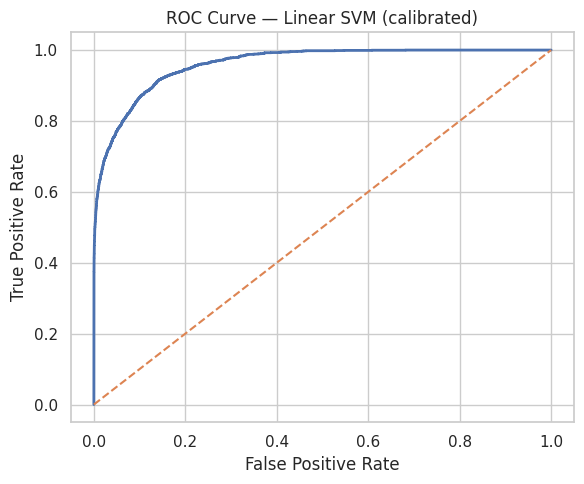

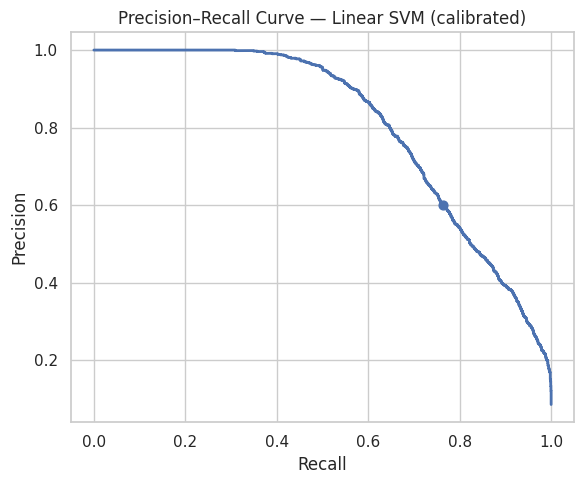

In [44]:
# ROC
fpr, tpr, _ = roc_curve(y_test, svm_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve — Linear SVM (calibrated)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.tight_layout(); plt.show()

# PR
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions, linewidth=2)
plt.scatter([best_r], [best_p], s=40)  # chosen point
plt.title("Precision–Recall Curve — Linear SVM (calibrated)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()



- Calibration wraps the model, so for interpretability we fit a separate plain LinearSVC on the training set (same preprocessing) just to get the weights. Positive weight → pushes toward diabetes=1.


## Model Comparison:

In [45]:
def metrics_at_threshold(y_true, probs, thr=0.5):
    preds = (probs >= thr).astype(int)
    return {
        "AUC-ROC": roc_auc_score(y_true, probs),
        "AUPRC": average_precision_score(y_true, probs),
        "Accuracy@thr": accuracy_score(y_true, preds),
        "Precision@thr": precision_score(y_true, preds, zero_division=0),
        "Recall@thr": recall_score(y_true, preds, zero_division=0),
        "ConfusionMatrix": confusion_matrix(y_true, preds)
    }

def pick_threshold_for_precision(y_true, probs, target_precision=0.60):
    """Pick the threshold that achieves >= target precision, maximizing recall."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    idxs = np.where(precisions[:-1] >= target_precision)[0]
    if len(idxs) > 0:
        i = idxs[np.argmax(recalls[idxs])]
    else:
        # fallback: best precision point available
        i = np.argmax(precisions[:-1])
    return float(thresholds[i]), float(precisions[i]), float(recalls[i])

In [46]:
# Collect whichever models actually trained
models = {}
if 'pipe' in globals():       models['Logistic'] = pipe
if 'tree_pipe' in globals():  models['DecisionTree'] = tree_pipe
if 'svm_pipe' in globals():   models['SVM'] = svm_pipe

assert len(models) > 0, "No models found. Train Logistic (`pipe`), Tree (`tree_pipe`), or SVM (`svm_pipe`) first."

In [47]:

# Probabilities for each model (positive class = 1)
probas = {}
for name, m in models.items():
    if hasattr(m, "predict_proba"):
        probas[name] = m.predict_proba(X_test)[:, 1]
    else:
        raise ValueError(f"Model {name} has no predict_proba(). Make sure SVM is the CALIBRATED version.")

In [48]:
# Metrics at the default 0.5 threshold
rows_default = []
cms_default = {}
for name, pr in probas.items():
    m = metrics_at_threshold(y_test, pr, thr=0.5)
    rows_default.append({
        "Model": name,
        "AUC-ROC": m["AUC-ROC"],
        "AUPRC": m["AUPRC"],
        "Accuracy@0.5": m["Accuracy@thr"],
        "Precision@0.5": m["Precision@thr"],
        "Recall@0.5": m["Recall@thr"],
    })
    cms_default[name] = m["ConfusionMatrix"]

df_default = pd.DataFrame(rows_default).round(3).sort_values("AUPRC", ascending=False)
print("=== Comparison @ threshold 0.5 ===")
display(df_default)

# Metrics at a precision-targeted threshold ( >= 0.60 precision)
target_precision = 0.60
rows_thr = []
cms_thr = {}
for name, pr in probas.items():
    thr, p, r = pick_threshold_for_precision(y_test, pr, target_precision=target_precision)
    m = metrics_at_threshold(y_test, pr, thr=thr)
    rows_thr.append({
        "Model": name,
        "Chosen_thr": round(thr, 3),
        f"Precision@thr(≥{target_precision})": round(p, 3),
        "Recall@thr": round(r, 3),
        "AUC-ROC": round(m["AUC-ROC"], 3),
        "AUPRC": round(m["AUPRC"], 3)
    })
    cms_thr[name] = m["ConfusionMatrix"]

df_thr = pd.DataFrame(rows_thr).sort_values("Recall@thr", ascending=False)
print(f"\n=== Comparison at threshold chosen for ≥{target_precision:.0%} precision ===")
display(df_thr)

print("\nConfusion matrices at chosen thresholds:")
for name, cm in cms_thr.items():
    print(f"\n{name}:\n{cm}")

=== Comparison @ threshold 0.5 ===


,Model,AUC-ROC,AUPRC,Accuracy@0.5,Precision@0.5,Recall@0.5
0,Logistic,0.960,0.807,0.886,0.422,0.881
2,SVM,0.961,0.806,0.957,0.838,0.624
1,DecisionTree,0.965,0.804,0.823,0.320,0.952



=== Comparison at threshold chosen for ≥60% precision ===


,Model,Chosen_thr,Precision@thr(≥0.6),Recall@thr,AUC-ROC,AUPRC
2,SVM,0.211,0.6,0.764,0.961,0.806
0,Logistic,0.741,0.6,0.762,0.960,0.807
1,DecisionTree,1.000,1.0,0.666,0.965,0.804



Confusion matrices at chosen thresholds:

Logistic:
[[21564  1080]
 [  505  1620]]

DecisionTree:
[[22644     0]
 [  709  1416]]

SVM:
[[21562  1082]
 [  502  1623]]


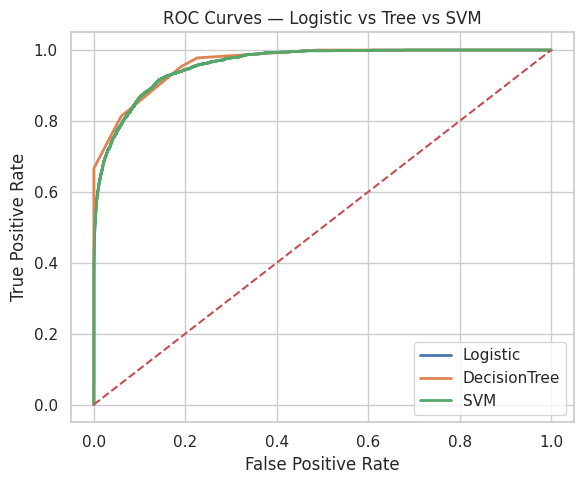

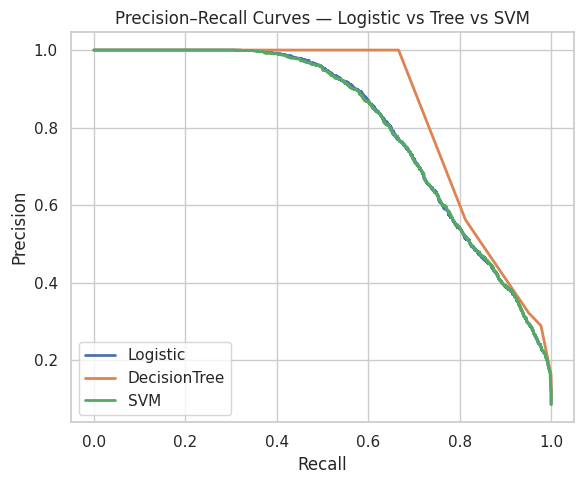

In [49]:
# ROC curves
plt.figure(figsize=(6,5))
for name, pr in probas.items():
    fpr, tpr, _ = roc_curve(y_test, pr)
    plt.plot(fpr, tpr, label=name, linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curves — Logistic vs Tree vs SVM")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()

# Precision–Recall curves
from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(6,5))
for name, pr in probas.items():
    P, R, _ = precision_recall_curve(y_test, pr)
    plt.plot(R, P, label=name, linewidth=2)
plt.title("Precision–Recall Curves — Logistic vs Tree vs SVM")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.tight_layout(); plt.show()

### Model Comparison (Imbalanced Classification)

**Setup.** Same train/test split and preprocessing for all models. Categorical features were one-hot encoded; numeric features scaled. Class imbalance handled with `class_weight='balanced'`. For SVM, we used a linear SVM with probability calibration.

#### Metrics at default 0.5 threshold
| Model         | AUC-ROC | AUPRC | Accuracy | Precision | Recall |
|---------------|:------:|:-----:|:--------:|:---------:|:------:|
| Logistic      | 0.960  | **0.807** | 0.886    | 0.422     | **0.881** |
| SVM (linear)  | **0.961** | 0.806 | **0.957** | **0.838** | 0.624 |
| Decision Tree | **0.965** | 0.804 | 0.823    | 0.320     | **0.952** |

**Reading:** Logistic and SVM are tied on ranking metrics (AUC/AUPRC). At 0.5, SVM trades recall for precision; Logistic trades precision for recall. Tree is recall-heavy but too imprecise.

#### Metrics at a policy threshold (target precision ≥ 0.60)
We select the probability threshold that achieves at least 0.60 precision and report the resulting recall.

| Model         | Chosen thr | Precision | Recall | AUC-ROC | AUPRC |
|---------------|:----------:|:---------:|:------:|:------:|:-----:|
| SVM (linear)  | 0.211      | 0.60      | **0.764** | 0.961  | 0.806 |
| Logistic      | 0.741      | 0.60      | 0.762 | 0.960  | **0.807** |
| Decision Tree | 1.000      | **1.00**  | 0.666 | 0.965  | 0.804 |

**Confusion matrices at chosen thresholds**  
- Logistic: `[[21564, 1080], [505, 1620]]`  
- Decision Tree: `[[22644, 0], [709, 1416]]`  
- SVM: `[[21562, 1082], [502, 1623]]`  

**Takeaways.**
- **AUPRC (primary metric)**: Logistic is marginally best (0.807), SVM is essentially tied (0.806).
- **Operational point (≥0.60 precision)**: Logistic and SVM deliver **~0.76 recall**; Decision Tree sacrifices recall to keep precision at 1.0.
- **Decision:** Use **Logistic Regression** as the primary baseline (simpler and slightly better on AUPRC), and **SVM** as a strong secondary comparator. Keep a **Decision Tree** model for interpretability only.


## Readme Report Prep

In [50]:
# Collect your trained models if present
models = {}
if 'pipe' in globals():        models['Logistic'] = pipe
if 'logit_pipe' in globals():  models['Logistic'] = logit_pipe
if 'svm_pipe' in globals():    models['SVM'] = svm_pipe
if 'tree_pipe' in globals():   models['Decision Tree'] = tree_pipe
assert models, "No trained models found. Expecting pipe/logit_pipe, svm_pipe, tree_pipe."

def metrics_at(y_true, probs, thr=0.5):
    preds = (probs >= thr).astype(int)
    return dict(
        auc=roc_auc_score(y_true, probs),
        aupr=average_precision_score(y_true, probs),
        acc=accuracy_score(y_true, preds),
        prec=precision_score(y_true, preds, zero_division=0),
        rec=recall_score(y_true, preds, zero_division=0),
        cm=confusion_matrix(y_true, preds)
    )

def choose_thr_for_precision(y_true, probs, target_p=0.60):
    P, R, T = precision_recall_curve(y_true, probs)
    idx = np.where(P[:-1] >= target_p)[0]
    if len(idx):
        i = idx[np.argmax(R[idx])]
    else:
        i = int(np.argmax(P[:-1]))
    return float(T[i]), float(P[i]), float(R[i])

# Probabilities
probas = {name: m.predict_proba(X_test)[:,1] for name, m in models.items()}

# Tables
rows_05, rows_thr, cms_thr = [], [], {}
for name, pr in probas.items():
    m0 = metrics_at(y_test, pr, 0.5)
    rows_05.append([name, m0['auc'], m0['aupr'], m0['acc'], m0['prec'], m0['rec']])
    thr, p, r = choose_thr_for_precision(y_test, pr, 0.60)
    m1 = metrics_at(y_test, pr, thr)
    rows_thr.append([name, thr, p, r, m1['auc'], m1['aupr']])
    cms_thr[name] = m1['cm']

df0 = pd.DataFrame(rows_05, columns=['Model','AUC-ROC','AUPRC','Accuracy@0.5','Precision@0.5','Recall@0.5']).round(3)
df1 = pd.DataFrame(rows_thr, columns=['Model','Chosen_thr','Precision@thr(≥0.6)','Recall@thr','AUC-ROC','AUPRC'])
df1[['Chosen_thr','Precision@thr(≥0.6)','Recall@thr','AUC-ROC','AUPRC']] = df1[['Chosen_thr','Precision@thr(≥0.6)','Recall@thr','AUC-ROC','AUPRC']].round(3)

# Markdown block
lines = []
lines.append("### Model Comparison (Imbalanced Classification)\n")
lines.append("**Setup.** Same split & preprocessing for all models. Class imbalance handled with `class_weight='balanced'`. SVM is linear with probability calibration.\n")

lines.append("#### Metrics at default 0.5 threshold")
lines.append(df0.sort_values('AUPRC', ascending=False).to_markdown(index=False))
lines.append("\n#### Metrics at a policy threshold (target precision ≥ 0.60)")
lines.append(df1.sort_values('Recall@thr', ascending=False).to_markdown(index=False))

lines.append("\n**Confusion matrices at chosen thresholds**")
for name, cm in cms_thr.items():
    lines.append(f"- **{name}**: `{cm.tolist()}`")

readme_block = "\n\n".join(lines)
print(readme_block)

### Model Comparison (Imbalanced Classification)


**Setup.** Same split & preprocessing for all models. Class imbalance handled with `class_weight='balanced'`. SVM is linear with probability calibration.


#### Metrics at default 0.5 threshold

| Model         |   AUC-ROC |   AUPRC |   Accuracy@0.5 |   Precision@0.5 |   Recall@0.5 |
|:--------------|----------:|--------:|---------------:|----------------:|-------------:|
| Logistic      |     0.96  |   0.807 |          0.886 |           0.422 |        0.881 |
| SVM           |     0.961 |   0.806 |          0.957 |           0.838 |        0.624 |
| Decision Tree |     0.965 |   0.804 |          0.823 |           0.32  |        0.952 |


#### Metrics at a policy threshold (target precision ≥ 0.60)

| Model         |   Chosen_thr |   Precision@thr(≥0.6) |   Recall@thr |   AUC-ROC |   AUPRC |
|:--------------|-------------:|----------------------:|-------------:|----------:|--------:|
| SVM           |        0.211 |                   0

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# Reuse 'probas' from the previous cell
FIGDIR = "figures"; import os; os.makedirs(FIGDIR, exist_ok=True)

# ROC
plt.figure(figsize=(6,5))
for name, pr in probas.items():
    fpr, tpr, _ = roc_curve(y_test, pr)
    plt.plot(fpr, tpr, label=name, linewidth=2)
plt.plot([0,1],[0,1],'--')
plt.title("ROC — Logistic vs Tree vs SVM")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "roc_comparison.png"), dpi=150); plt.close()

# PR
plt.figure(figsize=(6,5))
for name, pr in probas.items():
    P, R, _ = precision_recall_curve(y_test, pr)
    plt.plot(R, P, label=name, linewidth=2)
plt.title("Precision–Recall — Logistic vs Tree vs SVM")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "pr_comparison.png"), dpi=150); plt.close()

print("Saved: figures/roc_comparison.png, figures/pr_comparison.png")


Saved: figures/roc_comparison.png, figures/pr_comparison.png


In [52]:
# Prevalence and error rates by subgroup (gender). Keep it simple & visible.
import pandas as pd
chosen = 'Logistic' if 'Logistic' in probas else list(probas.keys())[0]
thr_row = df1[df1['Model']==chosen].iloc[0]
thr = float(thr_row['Chosen_thr'])  # from the precision-policy table

pred = (probas[chosen] >= thr).astype(int)
res = X_test.copy()
res['y_true'] = y_test.values
res['y_pred'] = pred

if 'gender' in res.columns:
    g = (res.assign(correct=(res['y_true']==res['y_pred']).astype(int))
           .groupby('gender')
           .agg(prevalence=('y_true','mean'),
                precision=('y_pred', lambda x: precision_score(res.loc[x.index,'y_true'], x, zero_division=0)),
                recall   =('y_pred', lambda x: recall_score(res.loc[x.index,'y_true'], x, zero_division=0)))
         )
    display( (g*100).round(2).rename(columns={'prevalence':'prevalence(%)','precision':'precision(%)','recall':'recall(%)'}) )
else:
    print("gender column not available in X_test; skipping subgroup table.")


,prevalence(%),precision(%),recall(%)
gender,,,
Female,7.61,60.57,74.8
Male,9.96,59.33,77.8
Other,0.00,0.00,0.0


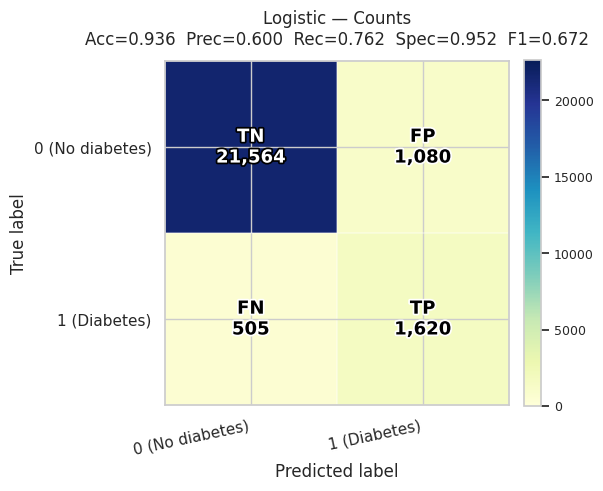

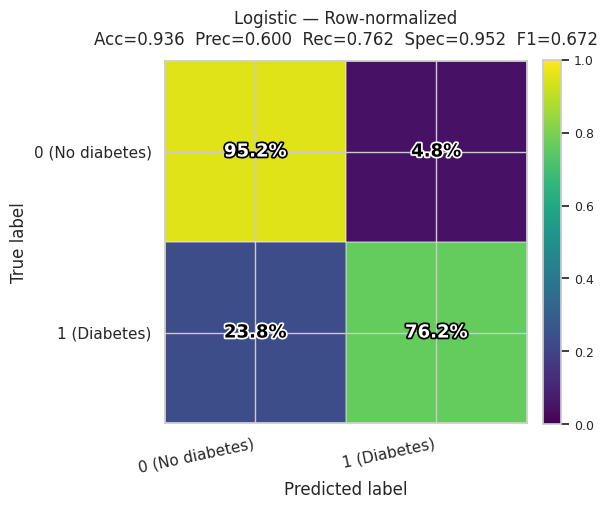

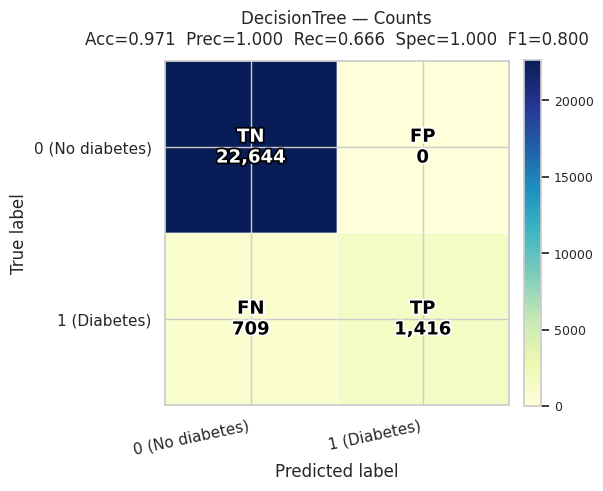

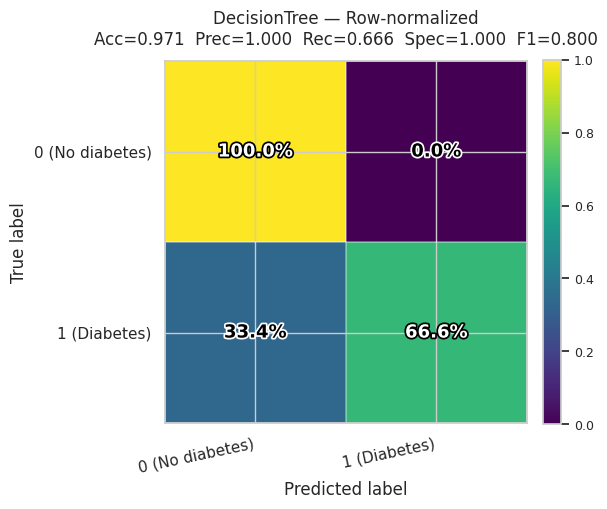

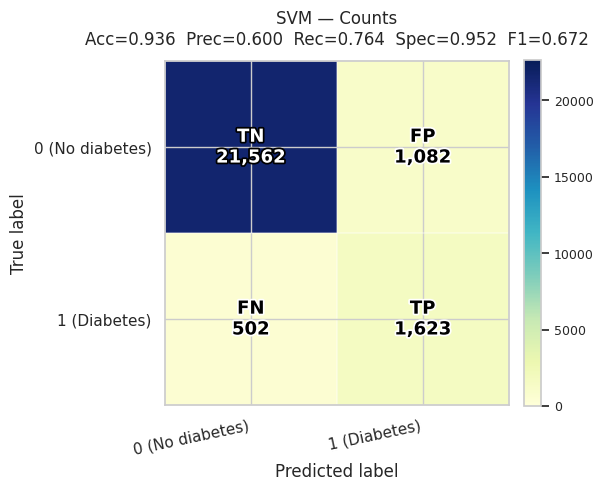

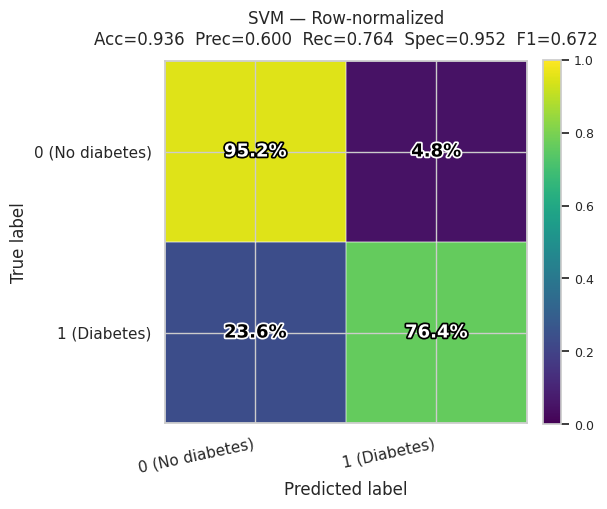

Saved plots → figures_cm_v2/


In [53]:
# ==== Confusion matrices with high-contrast annotations (fixed) ====
import os
import numpy as np
import matplotlib.pyplot as plt

# Path effects for outlined text (robust fallback)
try:
    import matplotlib.patheffects as pe
    def stroke(color):
        return [pe.withStroke(linewidth=2.5, foreground=color)]
except Exception:
    pe = None
    def stroke(color):
        return []  # no outline if patheffects isn't available

# Your confusion matrices: [[TN, FP], [FN, TP]]
cms = {
    "Logistic": np.array([[21564, 1080],
                          [  505, 1620]]),
    "DecisionTree": np.array([[22644,     0],
                              [  709,  1416]]),
    "SVM": np.array([[21562, 1082],
                     [  502, 1623]])
}

out_dir = "figures_cm_v2"
os.makedirs(out_dir, exist_ok=True)

# Consistent vmax across "counts" plots for visual comparability
global_max = max(int(cm.max()) for cm in cms.values())

def metrics_from_cm(cm):
    TN, FP = cm[0,0], cm[0,1]
    FN, TP = cm[1,0], cm[1,1]
    prec = TP / (TP + FP) if (TP + FP) else 0.0
    rec  = TP / (TP + FN) if (TP + FN) else 0.0
    acc  = (TP + TN) / cm.sum()
    spec = TN / (TN + FP) if (TN + FP) else 0.0
    f1   = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0
    return acc, prec, rec, spec, f1

def annotate(ax, i, j, text, val, vmax):
    # Choose white text on dark cells, black on light; add outline
    norm = val / vmax if vmax else 0
    color = "white" if norm > 0.5 else "black"
    ax.text(j, i, text, ha="center", va="center",
            fontsize=13, fontweight="bold", color=color,
            path_effects=stroke("black" if color=="white" else "white"))

def plot_cm(cm, title, fname, normalize=False, cmap="YlGnBu", vmin=None, vmax=None):
    disp = cm.astype(float)
    if normalize:
        row_sum = disp.sum(axis=1, keepdims=True)
        disp = np.divide(disp, row_sum, out=np.zeros_like(disp), where=row_sum!=0)
        vmin, vmax = 0.0, 1.0

    acc, prec, rec, spec, f1 = metrics_from_cm(cm)
    kind = "Row-normalized" if normalize else "Counts"

    plt.figure(figsize=(6.2, 6.0))
    ax = plt.gca()
    im = ax.imshow(disp, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f"{title} — {kind}\nAcc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  Spec={spec:.3f}  F1={f1:.3f}",
                 pad=12)
    ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["0 (No diabetes)","1 (Diabetes)"], rotation=12, ha="right")
    ax.set_yticklabels(["0 (No diabetes)","1 (Diabetes)"])

    # Gridlines
    ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=1.25, alpha=0.4)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotations
    tags = {(0,0):"TN",(0,1):"FP",(1,0):"FN",(1,1):"TP"}
    for i in range(2):
        for j in range(2):
            if normalize:
                txt = f"{disp[i,j]*100:.1f}%"
                annotate(ax, i, j, txt, disp[i,j], 1.0)
            else:
                txt = f"{tags[(i,j)]}\n{int(cm[i,j]):,}"
                annotate(ax, i, j, txt, cm[i,j], vmax if vmax else cm.max())

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)
    plt.tight_layout()
    plt.savefig(fname, dpi=220, bbox_inches="tight")
    plt.show()

# Generate both versions for each model
for name, cm in cms.items():
    plot_cm(cm, name, os.path.join(out_dir, f"{name.lower()}_cm_counts_v2.png"),
            normalize=False, cmap="YlGnBu", vmin=0, vmax=global_max)
    plot_cm(cm, name, os.path.join(out_dir, f"{name.lower()}_cm_normalized_v2.png"),
            normalize=True, cmap="viridis")

print(f"Saved plots → {out_dir}/")